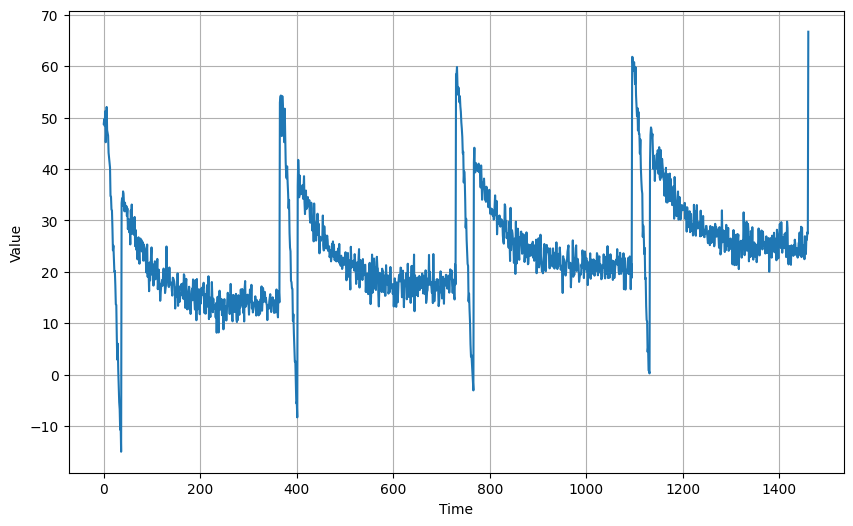

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time=np.arange(4*365+1,dtype="float32")
baseline=10
series=trend(time,0.1)
amplitude=40
slope=0.01
noise_level=2

# Create the series
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
# Add noise
series+=noise(time,noise_level,seed=40)


plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

Now that we have the time series, let's split it so we can start forecasting

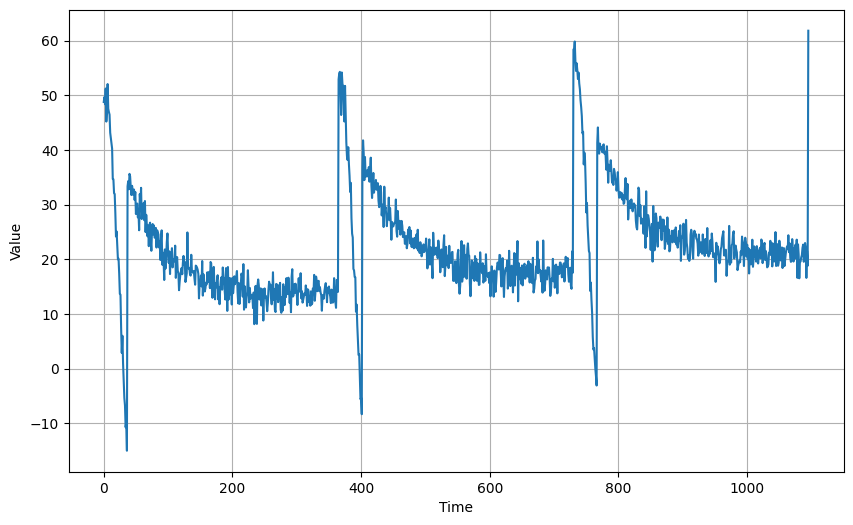

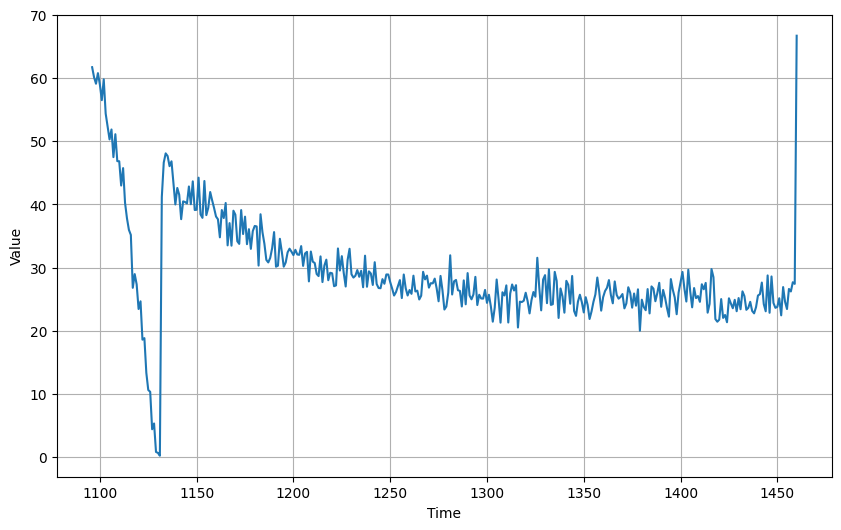

In [2]:
split_time=365*3+1
time_train=time[:split_time]
time_valid=time[split_time:]

x_train=series[:split_time]
x_valid=series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

#Naive Forecast

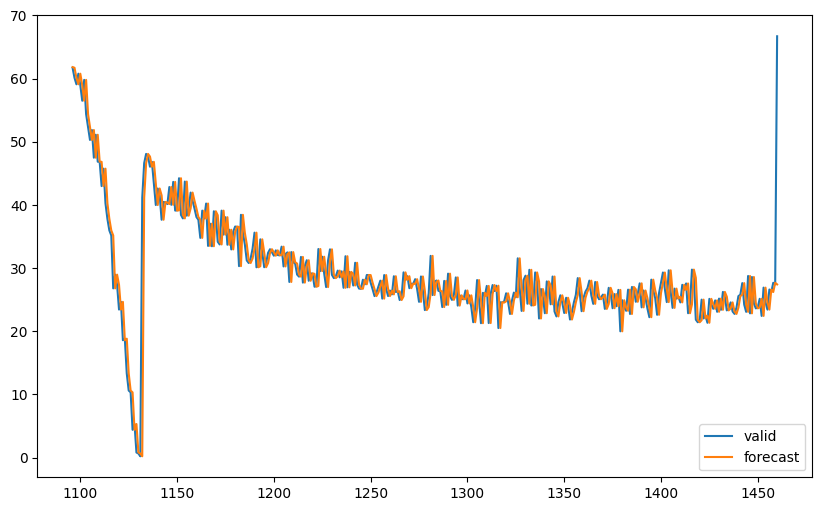

In [5]:
naive_forecast=series[split_time-1:-1]

plt.figure(figsize=(10, 6))
#plot_series(time_valid, x_valid)
#plot_series(time_valid, naive_forecast)
plt.plot(time_valid, x_valid,label="valid")
plt.plot(time_valid, naive_forecast,label="forecast")
plt.legend()
plt.show()

Let's zoom in on the start of the validation period:

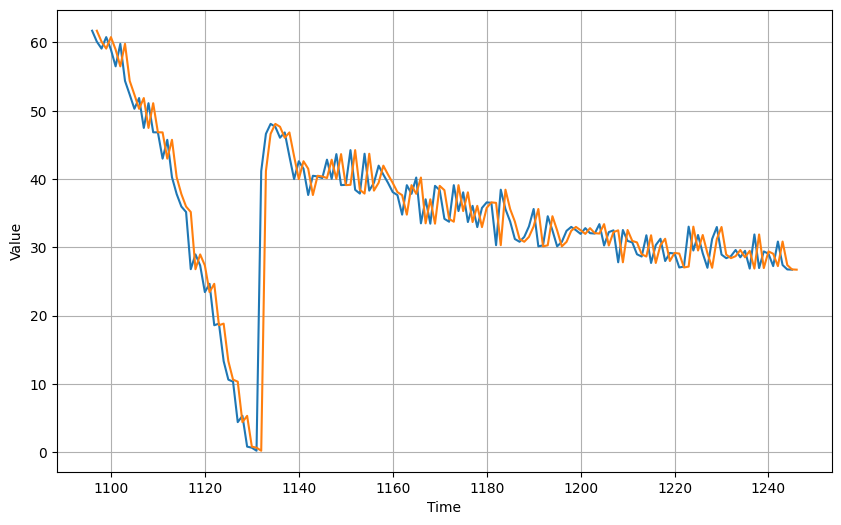

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [6]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

17.244425
2.530893


That's our baseline, now let's try a moving average:

In [9]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast"""
### START CODE HERE
    forecast=[]

    for time in range(len(series)-window_size):
      forecast.append(series[time:time+window_size].mean())
    return np.array(forecast)
### END CODE HERE

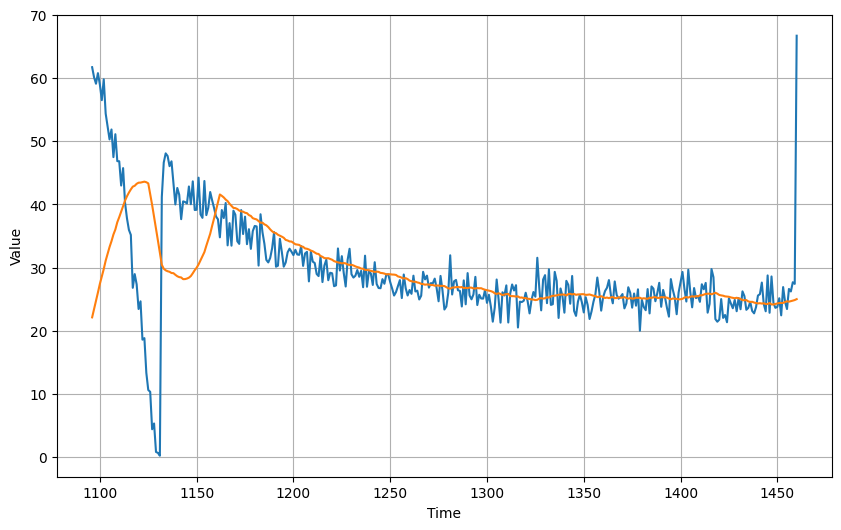

In [11]:
window_size=30

moving_avg=moving_average_forecast(series,window_size)[split_time-window_size:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

# EXPECTED OUTPUT
# CHart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

In [12]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# EXPECTED OUTPUT
# 65.786224
# 4.3040023

80.10181
4.7049656


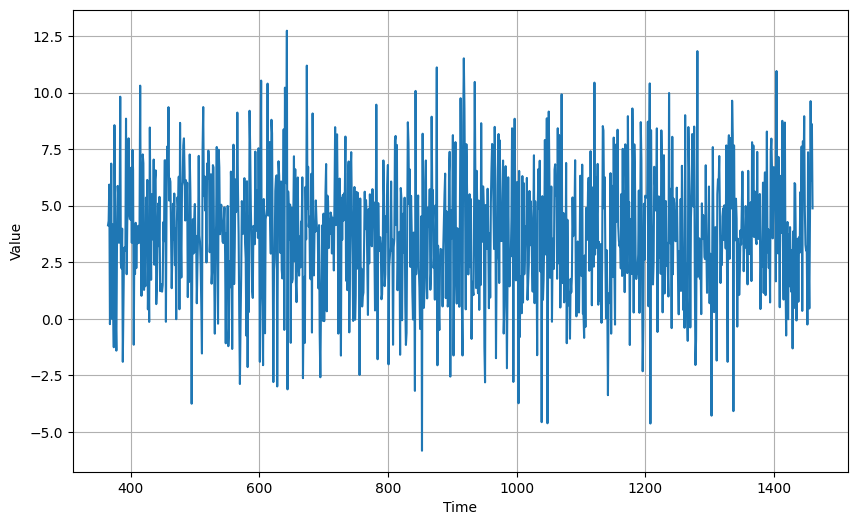

In [13]:
diff_size=365

diff_series=(series[diff_size:]-series[:-diff_size])
diff_time=time[diff_size:]
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

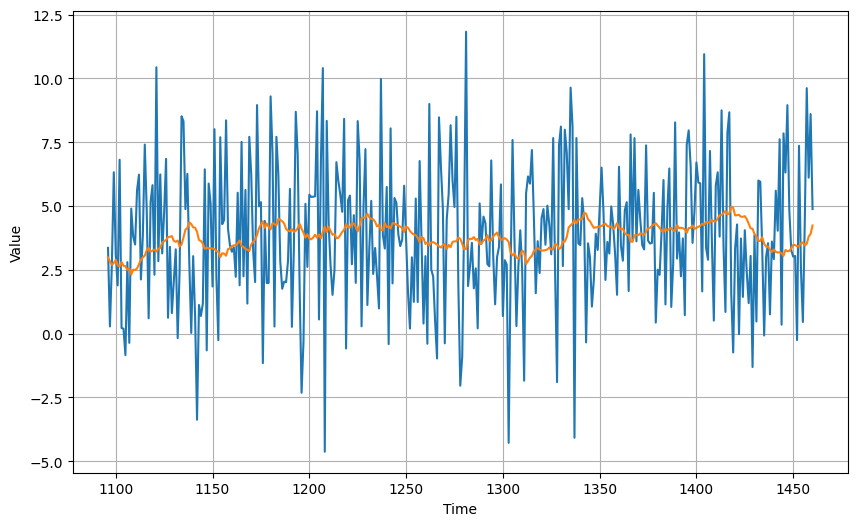

In [14]:
diff_moving_avg = moving_average_forecast(diff_series, window_size)[split_time-diff_size-window_size:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time-diff_size:])
plot_series(time_valid, diff_moving_avg)
plt.show()

# Expected output. Diff chart from 1100->1450 +
# Overlaid with moving average

Now let's bring back the trend and seasonality by adding the past values from t – 365:

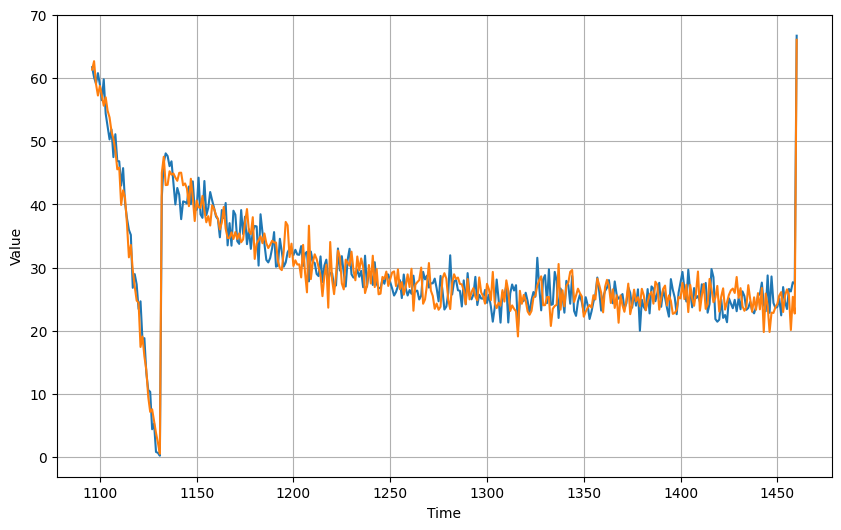

In [15]:
diff_moving_avg_plus_past = series[split_time - diff_size:-diff_size] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [16]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())
# EXPECTED OUTPUT
# 8.498155
# 2.327179

8.152229
2.286855


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

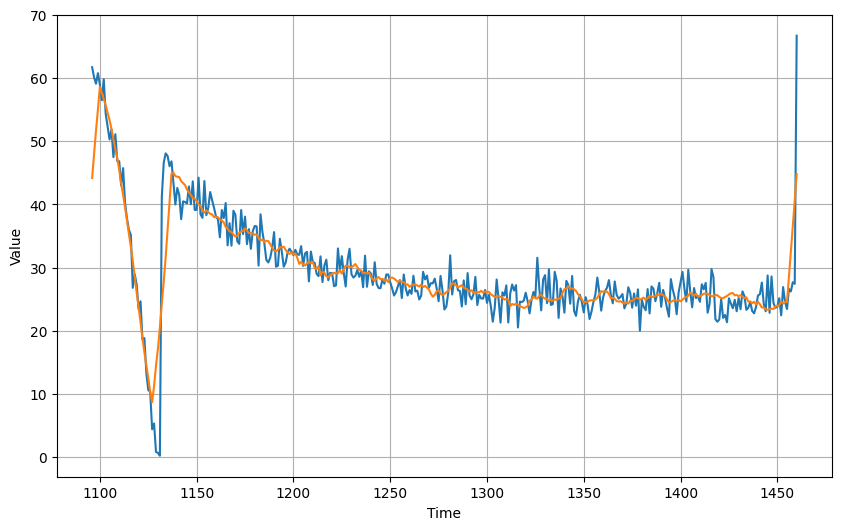

In [17]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

# EXPECTED OUTPUT:
# Similar chart to above, but the overlaid projections are much smoother

In [18]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
# EXPECTED OUTPUT
# 12.527958
# 2.2034433

13.359929
2.2286239
